In [23]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# OBSERVADOR DE ESTADO DE ORDEM PLENA

In [24]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [25]:
s = ctl.TransferFunction.s

G = 97123.0366515921/(1.0*s**2 + 684974.722594433*s - 1324231.64800177)
G

TransferFunction(array([97123.03665159]), array([ 1.00000000e+00,  6.84974723e+05, -1.32423165e+06]))

polos:  (-684976.656+0j) (1.933+0j)
zeros: 


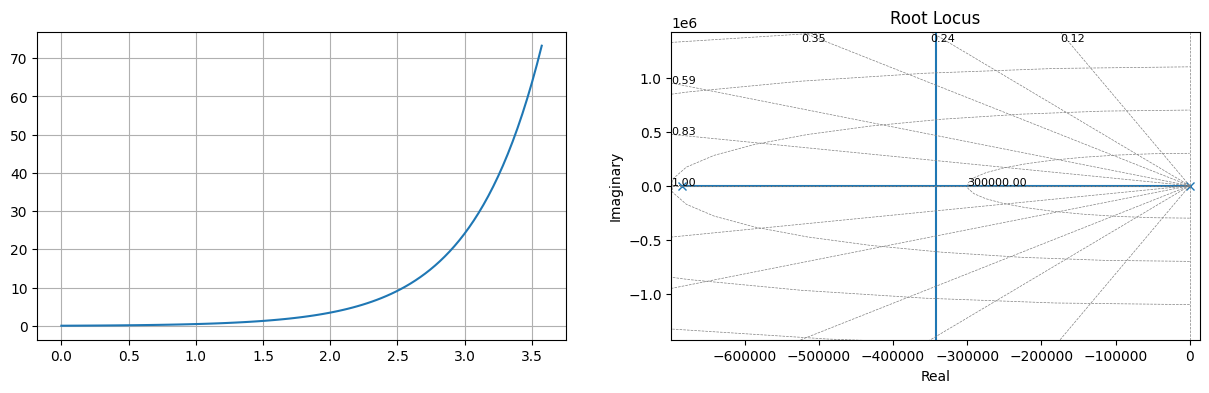

In [26]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# REQUISITOS DE CONTROLE

In [27]:
Ts = 10.00
UP = 0.20

- $\zeta = -\frac{ln(UP\%)}{\sqrt{\pi² + ln²(UP\%)}}$

In [28]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.4559498107691261

- $\omega_n = \frac{4}{\zeta\,t_s}$ 

In [29]:
Wn = 4/(zeta*Ts)
Wn

0.8772895405423105

- $s_d = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [30]:
s1 = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*1j
s2 = -zeta*Wn - Wn*np.sqrt(1-zeta**2)*1j
s3 = -10                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)
s4 = -10                                    # 2 a 5 vezes mais distante dos polos dominantes (parte real)

p = [np.round(val, 2) for val in [s1, s2, s3, s4]]
p

[(-0.4+0.78j), (-0.4-0.78j), -10, -10]

# ESPAÇO DE ESTADOS
- Forma padrão (computacional)

In [31]:
matrix = ctl.tf2ss(G)
A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D

display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[-684974.722594433, 1324231.64800177],
[              1.0,                0]])

Matrix([
[1.0],
[  0]])

Matrix([[0, 97123.0366515921]])

Matrix([[0]])

- Forma variáveis de fase (convencional)

In [32]:
def getVariaveisFase(G):
    matrix = ctl.tf2ss(G)
    A, B, C, D = matrix.A, matrix.B, matrix.C, matrix.D
    
    n = A.shape[0]

    # Cria uma matriz P com elementos 1 na diagonal secundária
    P = np.fliplr(np.eye(n))

    # Calcula a inversa da matriz P
    P_inv = np.linalg.inv(P)

    # Realiza as operações para obter a forma de variáveis de fase
    A = P_inv @ A @ P
    B = P_inv @ B
    C = C @ P
    D = D
    
    return A, B, C, D

A, B, C, D = getVariaveisFase(G)
display(sp.Matrix(A))
display(sp.Matrix(B))
display(sp.Matrix(C))
display(sp.Matrix(D))

Matrix([
[               0,               1.0],
[1324231.64800177, -684974.722594433]])

Matrix([
[  0],
[1.0]])

Matrix([[97123.0366515921, 0]])

Matrix([[0]])

In [33]:
n = sp.shape(A)[0]
n

2

# CONTROLADOR

In [34]:
K = ctl.acker(A, B, p)
#K = ctl.place(A, B, p)

sp.Matrix(K)

Matrix([[6.21299624465161e+17, -3.21375598964281e+17]])

In [35]:
L = ctl.acker(A.T, C.T, p).T
#L = ctl.place(A.T, C.T, p).T

sp.Matrix(L)

Matrix([
[    -3308953365174.8],
[2.26655581042517e+18]])

In [36]:
s = sp.symbols('s')
I = sp.eye(n) 
A, B, C, D = sp.Matrix(A), sp.Matrix(B), sp.Matrix(C), sp.Matrix(D)

- O controlador é obtido usando $C(s) = K(sI-A + LC + BK)^{-1}L$

In [37]:
C = K*(s*I - A + L*C + B*K).inv()*L
C = C[0].expand().simplify().factor().cancel()
C = roundSympyFunction(C)
C

-7.05269622802734*s - 11.4057006835938

# RESPOSTA CONTROLADA

In [38]:
s = ctl.TransferFunction.s
C = eval(str(C))
C

TransferFunction(array([ -7.05269623, -11.40570068]), array([1]))

In [39]:
G_ma = G*C
G_ma

TransferFunction(array([ -684979.27424724, -1107756.28552977]), array([ 1.00000000e+00,  6.84974723e+05, -1.32423165e+06]))

In [40]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([ -684979.27424724, -1107756.28552977]), array([ 1.00000000e+00, -4.55165281e+00, -2.43198793e+06]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

In [41]:
[np.round(val, 3) for val in list(ctl.poles(G_feedback))]

[(1561.761+0j), (-1557.209+0j)]

polos:  (1561.761+0j) (-1557.209+0j)
zeros:  (-1.617+0j)


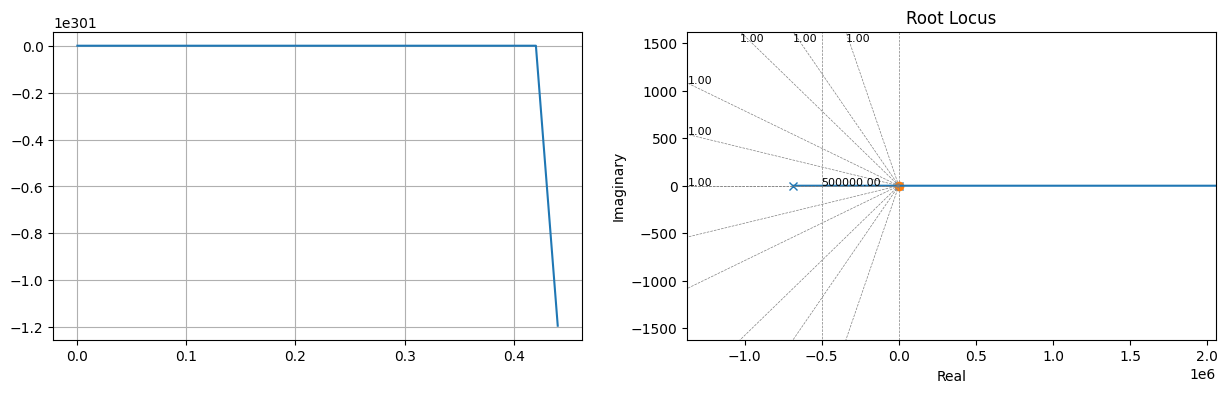

In [42]:
poles = ctl.poles(G_feedback)
zeros = ctl.zeros(G_feedback)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G_feedback, T=np.linspace(0, 2*Ts, 1000))
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [43]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  nan
valor de pico:  0.0
tempo de pico:  0.0
tempo de assentamento:  0.46046046046046046
valor final:  -inf
erro:  inf


C:\Users\march\AppData\Local\Temp\ipykernel_7540\3003588735.py:4: RuntimeWarning: invalid value encountered in scalar divide
  overshoot = (peak_value - steady_state_value) / steady_state_value


# APLICANDO VÁRIOS STEPS

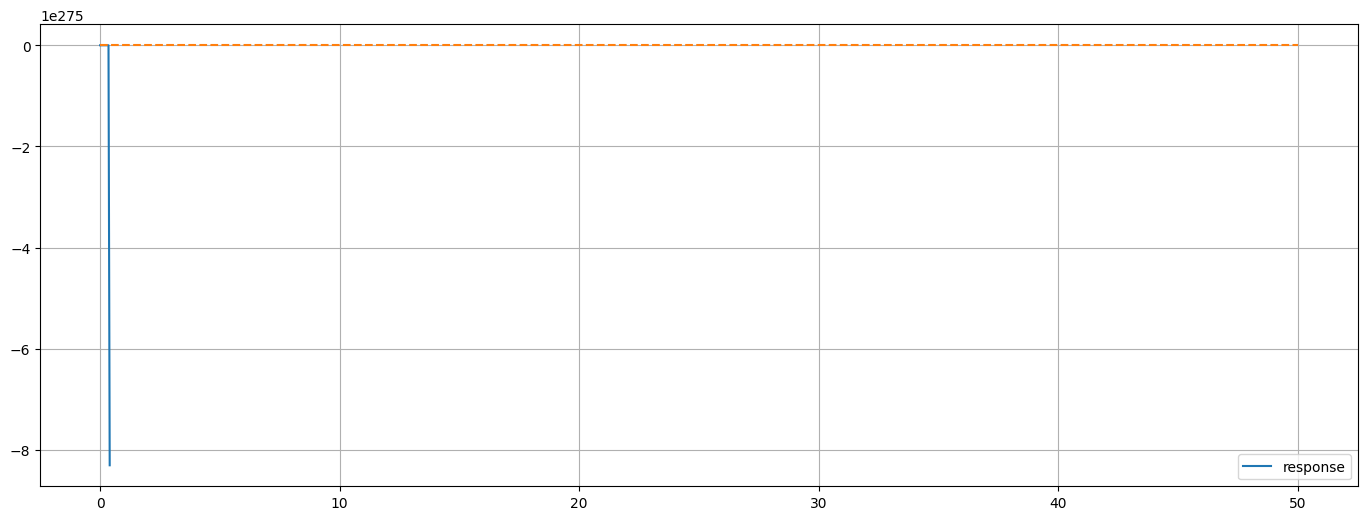

In [44]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 50, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()